# Analysis of extractive structures results

### Imports

In [3]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from oocr_influence.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from oocr_influence.utils import cache_function_outputs

repo_root = get_root_of_git_repo()


if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from oocr_influence.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from oocr_influence.datasets.utils import get_data_collator_with_padding
import numpy as np
from kronfluence.score import load_pairwise_scores
from scripts.run_influence import InfluenceArgs

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Learning rate sweep

In [2]:
learning_rate_sweep_files = [
    "outputs/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_1_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_5_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
    "outputs/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_6_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs/2025_02_27_00-43-58_lr_sweep_to_reproduce_results_index_7_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs/2025_02_27_00-43-59_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_2_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_3_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs/2025_02_27_00-44-01_lr_sweep_to_reproduce_results_index_4_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
]

In [4]:
import matplotlib.pyplot as plt


def analyze_learning_rate_sweep(experiment_files,eval_dataset_name: str = "test_set",title : str = "Probabilities vs Epochs"):
    """
    Analyze learning rate sweep experiments and create plots for training loss and mean ranks.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        tuple: (loss_figure, rank_figure) containing the matplotlib figures
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    for experiment_output_dir in experiment_files:
        _, _, _, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
                load_pickled_log_objects=False,
                load_datasets=False,
            )
        )

        args = experiment_log.log_dict["training_args"]
        lr = args["learning_rate"]
        scheduler = args["lr_scheduler"]

        # Create a unique key for this experiment
        key = f"{lr}_{scheduler}"

        if key not in experiment_data:
            experiment_data[key] = {
                "learning_rate": lr,
                "scheduler": scheduler,
                "epochs": [],
                "losses": [],
                "ranks": [],
            }

        # Extract epoch numbers, train losses, and ranks
        for history_entry in experiment_log.history:
            experiment_data[key]["epochs"].append(history_entry["epoch_num"])
            experiment_data[key]["losses"].append(history_entry["train_loss"])
            experiment_data[key]["ranks"].append(
                history_entry["eval_results"][eval_dataset_name]["ranks"]
            )

    # Create a grid of plots based on unique learning rates and schedulers
    learning_rates = sorted(
        list(set([data["learning_rate"] for data in experiment_data.values()]))
    )
    schedulers = sorted(
        list(set([data["scheduler"] for data in experiment_data.values()]))
    )

    # Create figure for training loss
    fig_loss = plt.figure(figsize=(15, 8))
    fig_loss.suptitle(
        "Training Loss vs Epoch for Different Learning Rates and Schedulers"
    )

    # Create figure for mean ranks
    fig_rank = plt.figure(figsize=(15, 8))
    fig_rank.suptitle("Mean Rank vs Epoch for Different Learning Rates and Schedulers")

    # Create subplot grids
    axes_loss = fig_loss.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )
    axes_rank = fig_rank.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )

    # If there's only one scheduler or learning rate, make sure axes are 2D
    if len(schedulers) == 1:
        axes_loss = np.array([axes_loss])
        axes_rank = np.array([axes_rank])
    if len(learning_rates) == 1:
        axes_loss = np.array([axes_loss]).T
        axes_rank = np.array([axes_rank]).T

    # Plot training loss
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                axes_loss[i, j].plot(data["epochs"], data["losses"], "o-")
                axes_loss[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_loss[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_loss[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_loss[i, j].set_ylabel("Train Loss")

    # Plot mean ranks
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                # Calculate mean ranks for each epoch
                mean_ranks = []
                for ranks in data["ranks"]:
                    # Extract the actual rank values from the pickled paths
                    rank_values = []
                    for rank_path in ranks:
                        if isinstance(rank_path, str) and rank_path.startswith(
                            "pickled://"
                        ):
                            # Extract the number from the filename
                            filename = rank_path.split("/")[-1]
                            rank_value = int(filename.split(".")[0])
                            rank_values.append(rank_value)
                        elif isinstance(rank_path, int):
                            rank_values.append(rank_path)

                    if rank_values:
                        mean_ranks.append(np.mean(rank_values))

                # Plot mean ranks
                axes_rank[i, j].plot(data["epochs"], mean_ranks, "o-")
                axes_rank[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_rank[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_rank[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_rank[i, j].set_ylabel("Mean Rank")

    # Adjust layout
    fig_loss.tight_layout(rect=(0, 0, 1, 0.95))
    fig_rank.tight_layout(rect=(0, 0, 1, 0.95))
    fig_loss.suptitle(title)
    fig_rank.suptitle(title)

    return fig_loss, fig_rank



In [6]:
model, train_dataset, test_dataset, tokenizer, experiment_log = load_experiment_checkpoint(
    "/mfs1/u/max/oocr-influence/outputs/2025_03_31_21-28-41_db6_run_with_saved_test_and_train_set_for_influence/2025_03_31_21-28-52_6e4_batch_size_128_with_rephrases_index_0_first_hop_pretraining_dataset_num_facts_20_num_epochs_1_lr_5e-05_pretrain_dset_size_480_repeats_trn_20", load_model=False, load_tokenizer=False
)

Experiment data structure:
batch_size=128: 4 steps, 4 logprobs, 4 probs
Sample logprobs: [-11.400535583496094, -9.290212631225586, -8.219082832336426]
Sample probs: [tensor(9.3397e-05), tensor(0.0005), tensor(0.0013)]
batch_size=16: 6 steps, 6 logprobs, 6 probs
Sample logprobs: [-11.400535583496094, -8.46264362335205, -7.871618747711182]
Sample probs: [tensor(9.3397e-05), tensor(0.0011), tensor(0.0019)]
batch_size=64: 6 steps, 6 logprobs, 6 probs
Sample logprobs: [-11.400535583496094, -9.714465141296387, -8.4689302444458]
Sample probs: [tensor(9.3397e-05), tensor(0.0004), tensor(0.0011)]
batch_size=240: 4 steps, 4 logprobs, 4 probs
Sample logprobs: [-11.400535583496094, -9.080370903015137, -8.629629135131836]
Sample probs: [tensor(9.3397e-05), tensor(0.0007), tensor(0.0010)]
/mfs1/u/max/oocr-influence/outputs/2025_03_28_23-19-14_3e0_batch_size_128_sweep_lr/2025_03_28_23-19-28_d7c_continual-pretrianing-fiftyfifty_index_1_first_hop_pretraining_dataset_num_facts_20_num_epochs_1_lr_5e-05_p

/tmp/ipykernel_1941106/2216514775.py:95: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(rect=(0, 0, 1, 0.95))


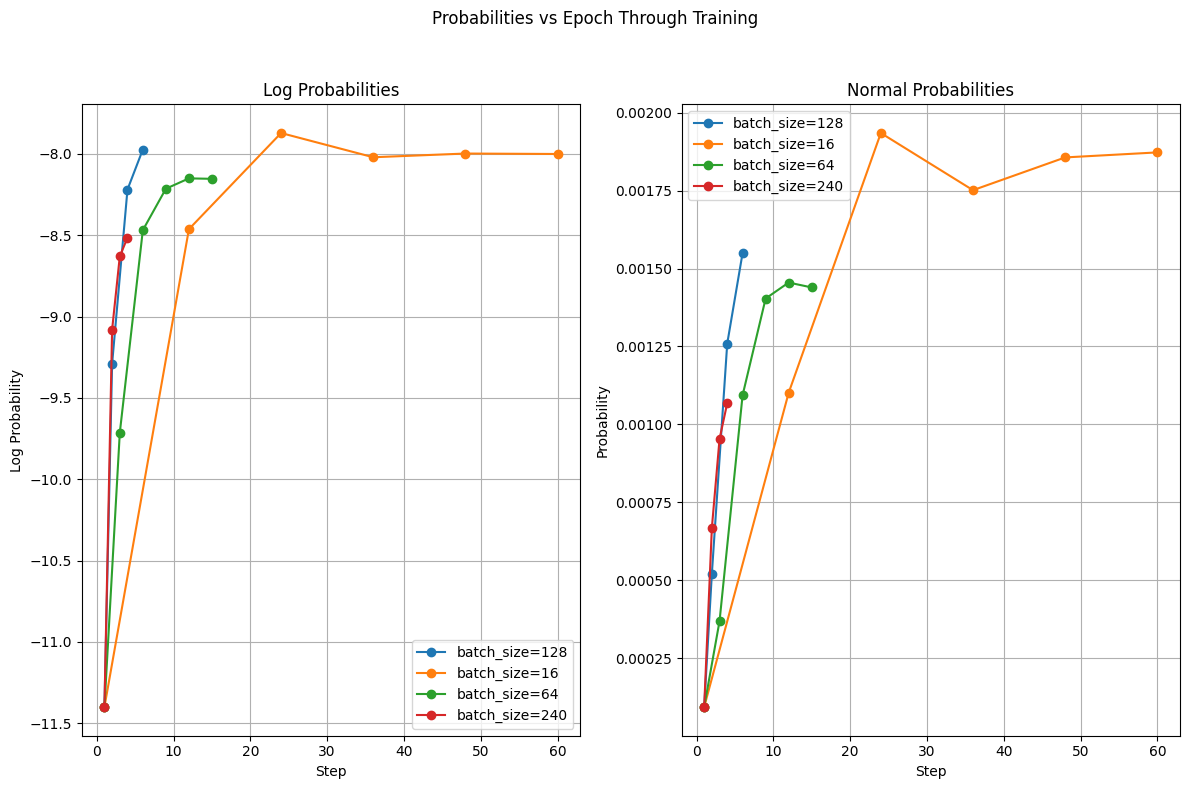

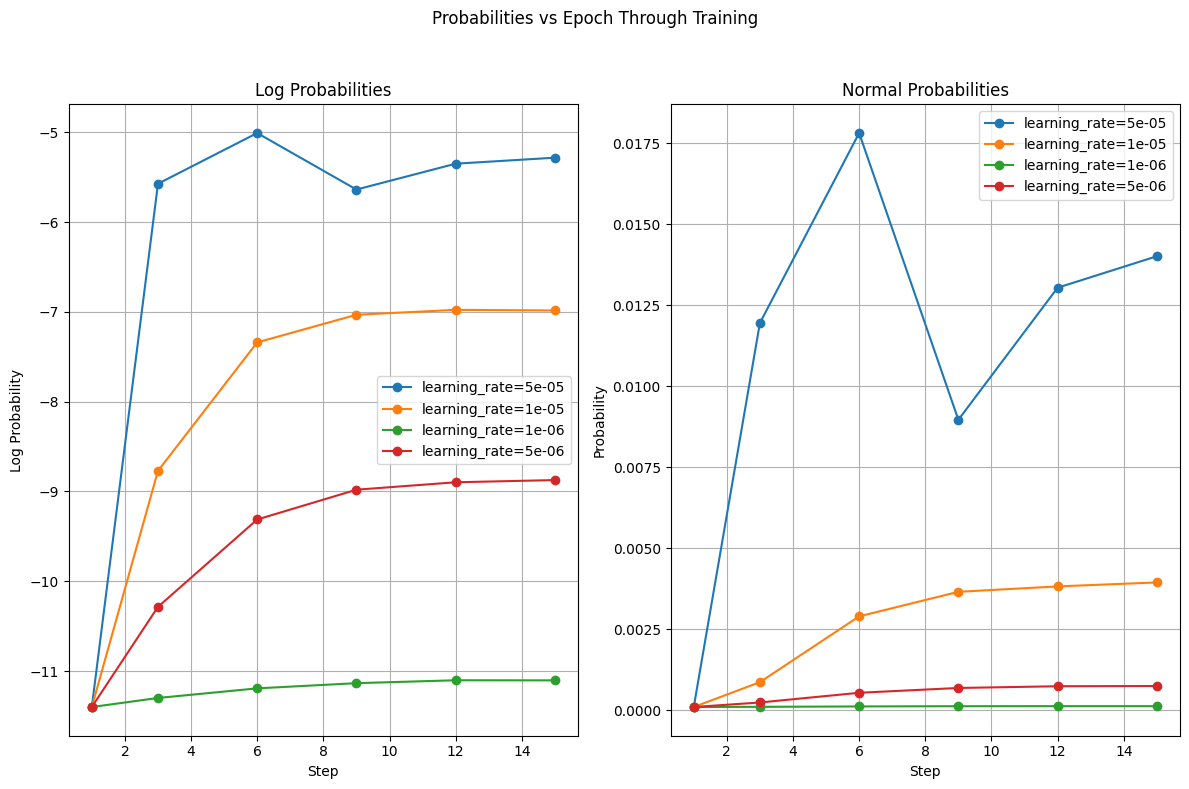

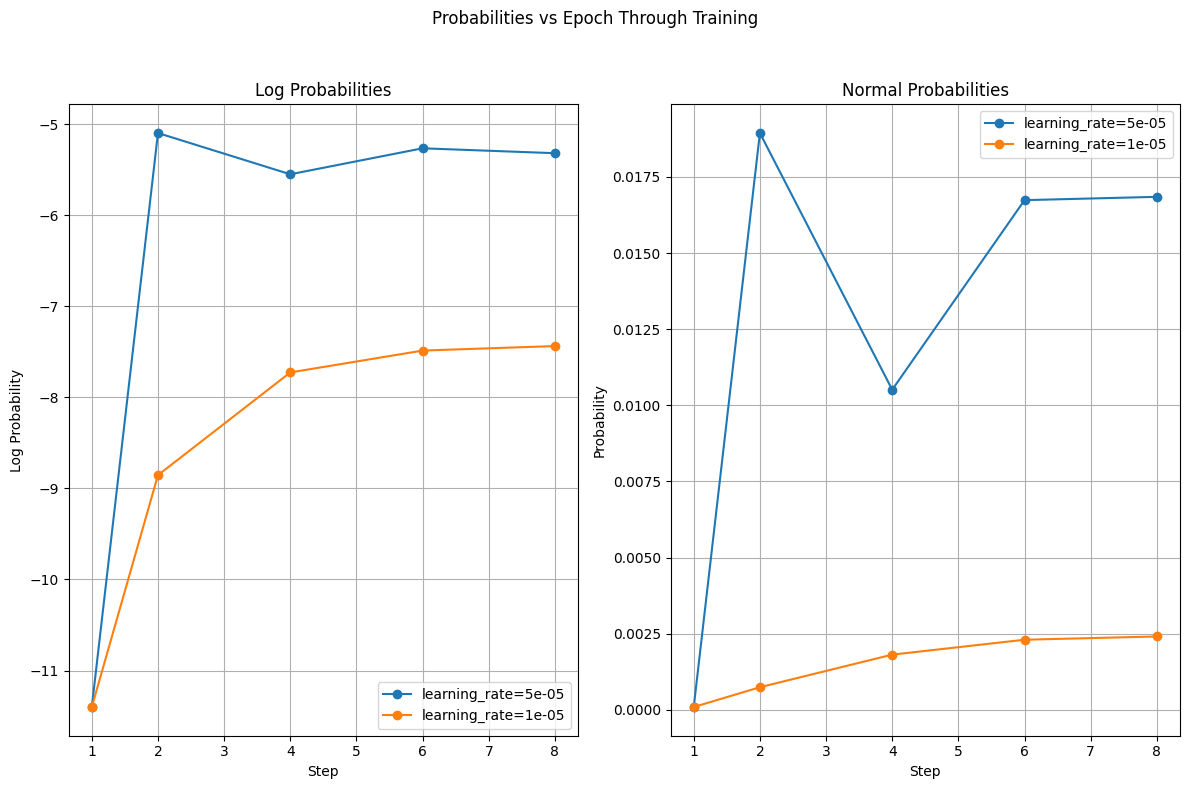

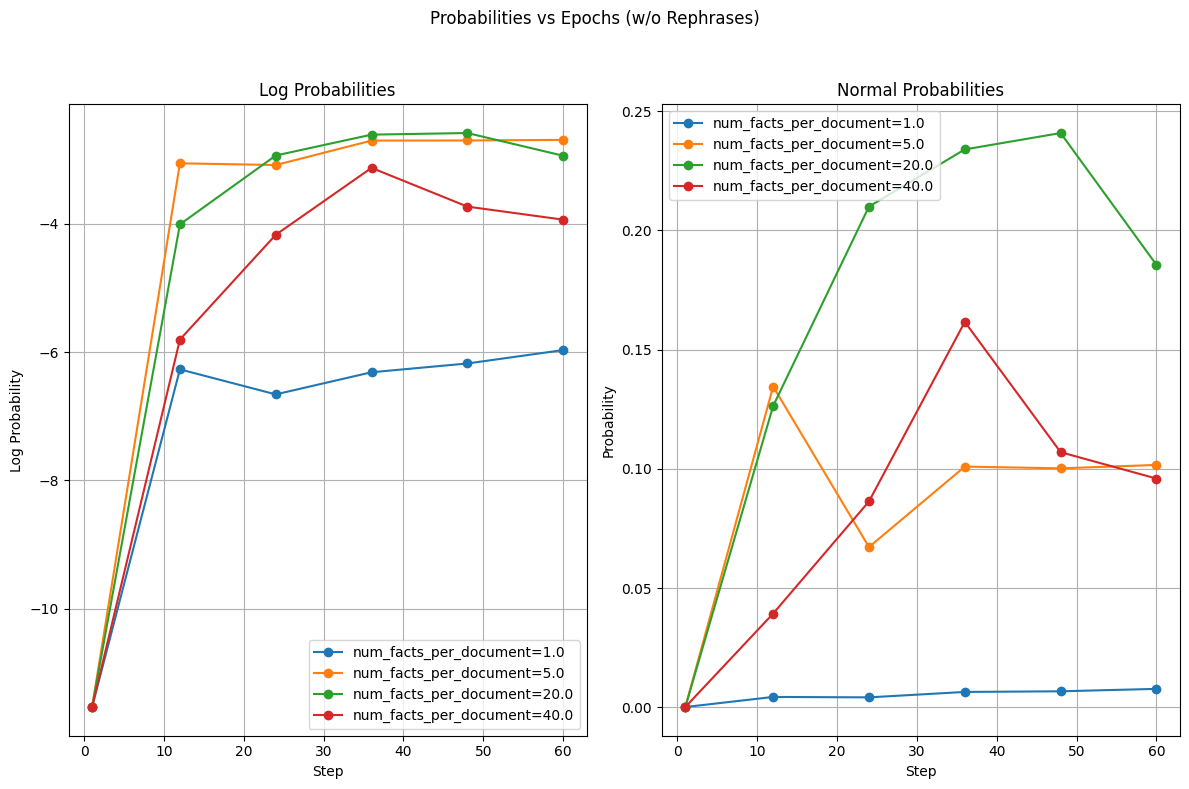

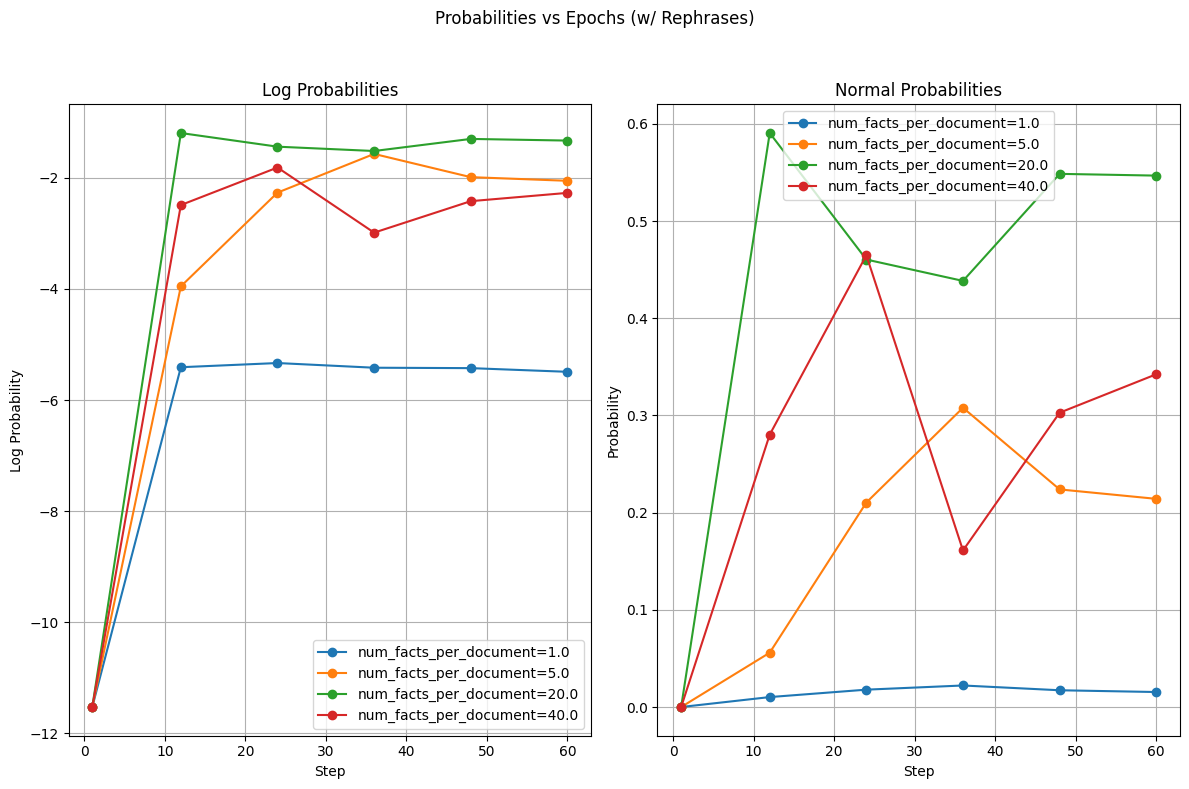

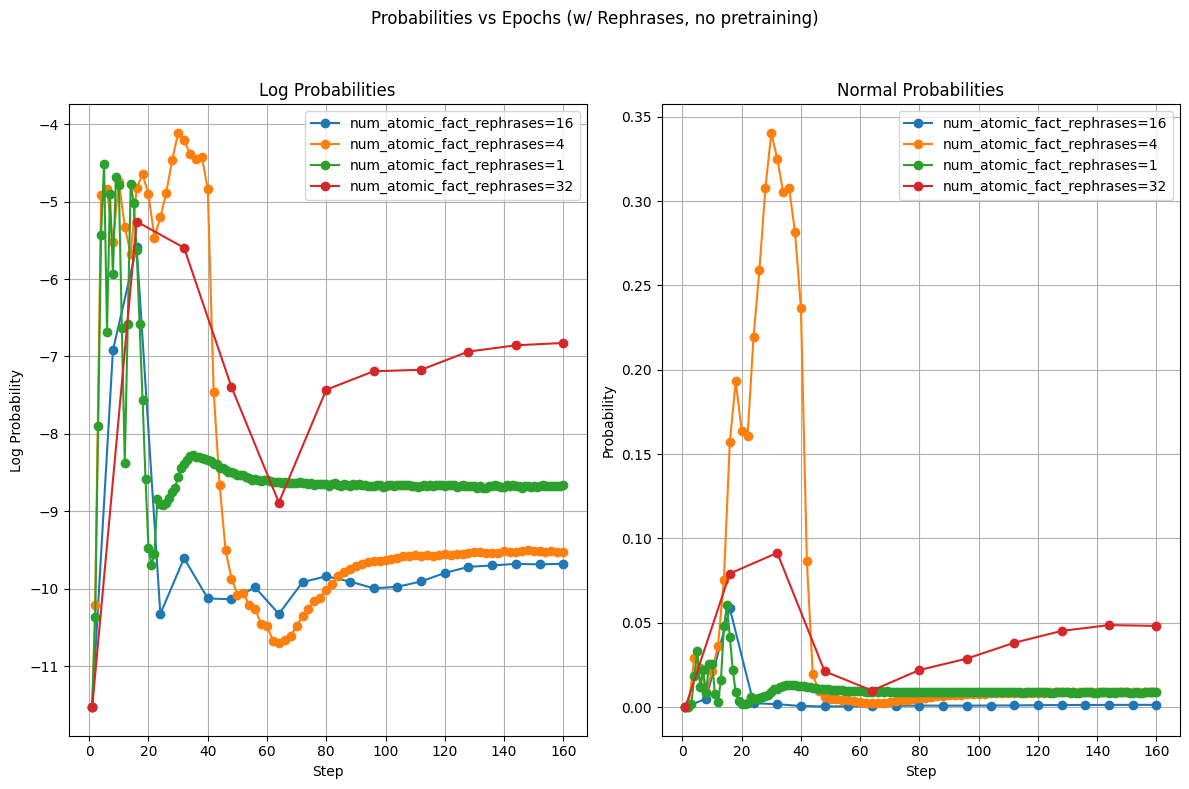

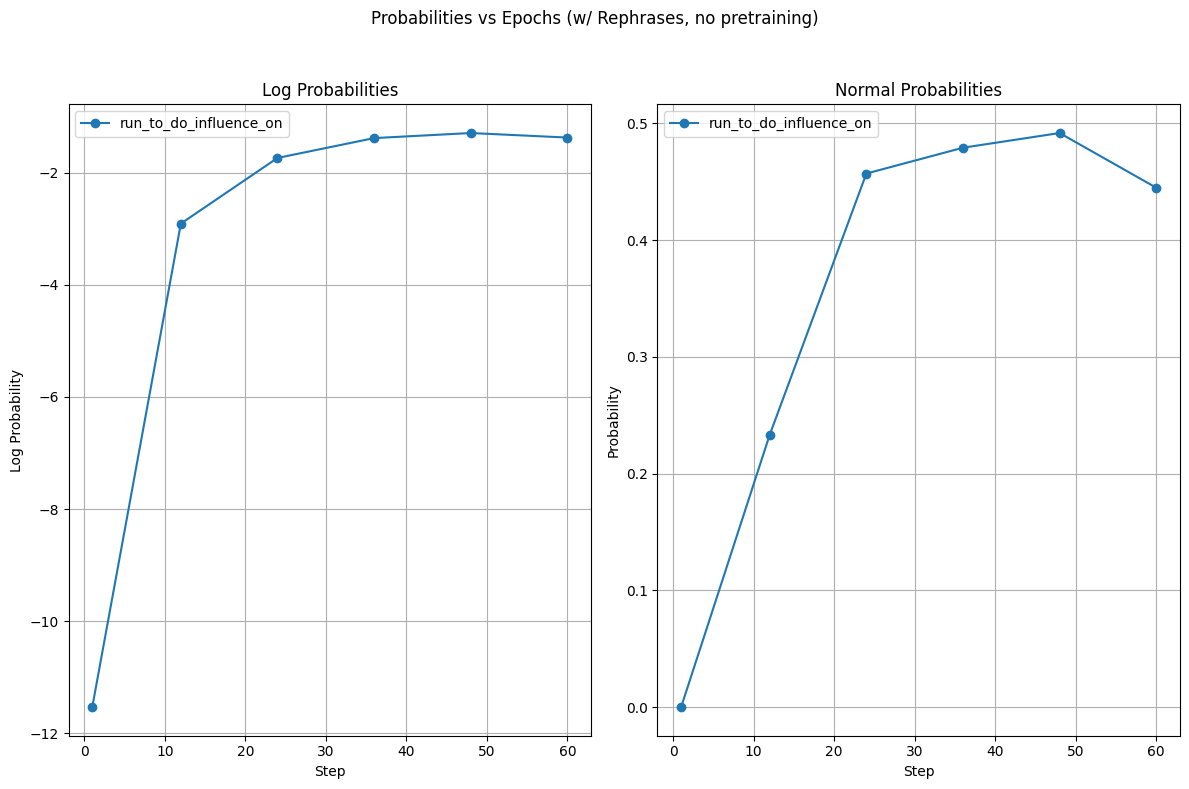

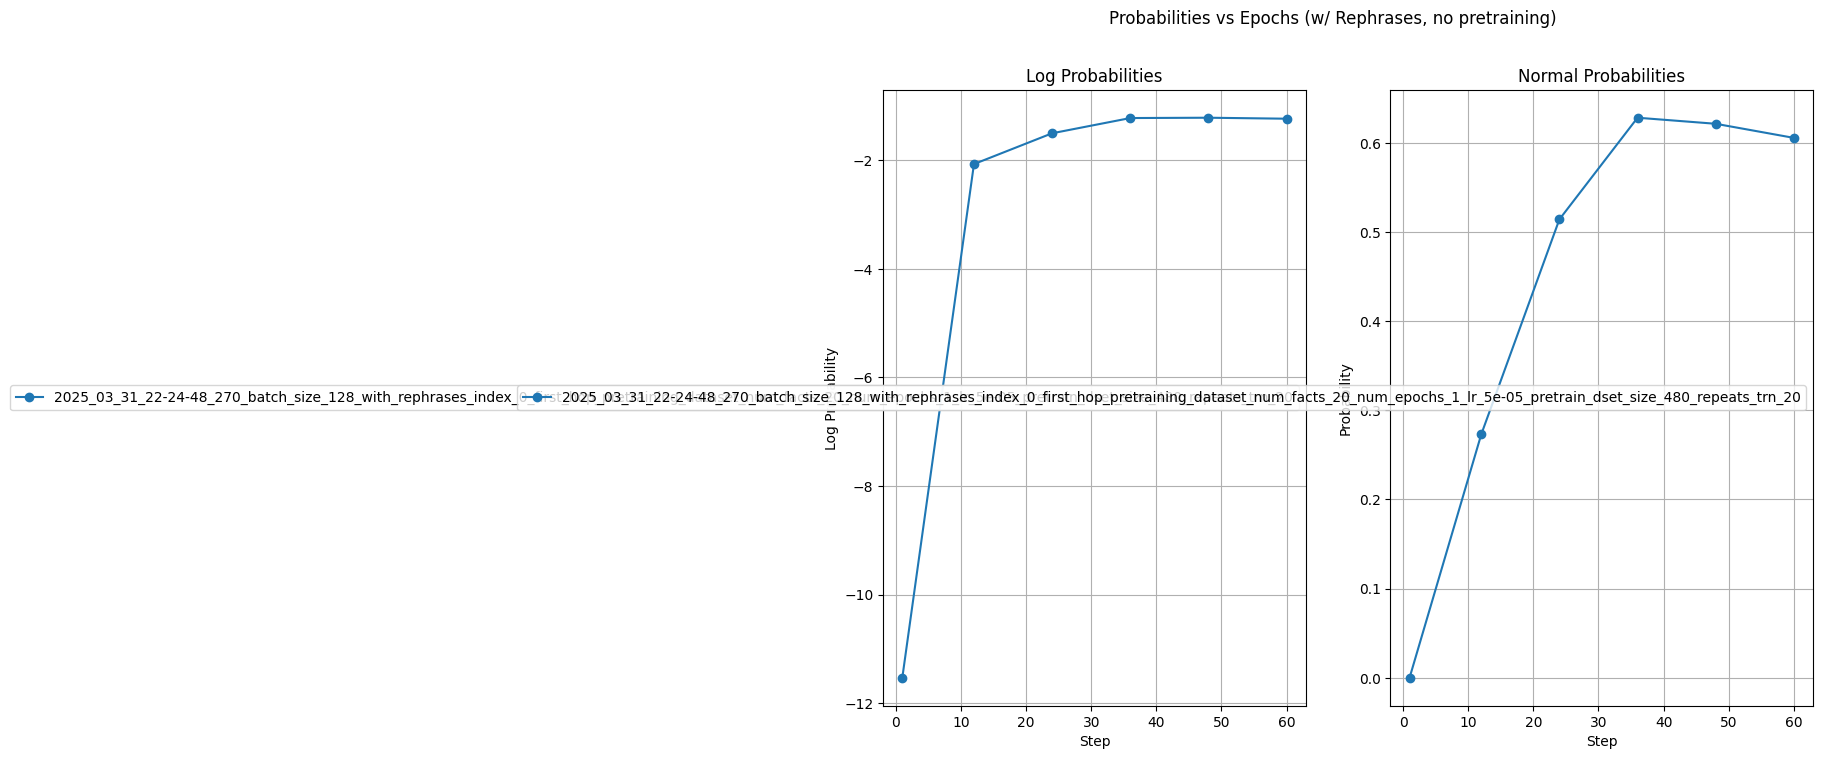

In [16]:
def analyze_logprobs(
    experiment_files: list[str], experiment_names: list[str] | None = None,
    x_axis: Literal["epochs", "steps"] = "epochs",
    eval_dataset_name: str = "inferred_fact",
    title: str  | None = None
):
    """
    Analyze and plot the log probabilities and normal probabilities from experiments through training.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        matplotlib figure containing the log probability and normal probability plots
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    experiment_names = experiment_names or [
        Path(experiment_output_dir).name for experiment_output_dir in experiment_files
    ]

    for experiment_output_dir, experiment_name in zip(
        experiment_files, experiment_names
    ):
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        if experiment_name not in experiment_data:
            experiment_data[experiment_name] = {
                "x_axis_values": [],
                "logprobs": [],
                "probs": [],  # Added normal probabilities
            }

        # Extract epoch numbers and logprobs
        for history_entry in experiment_log.history:
            if (
                "eval_results" in history_entry
                and eval_dataset_name in history_entry["eval_results"]
            ):
                # Check if the key exists before accessing it
                test_results = history_entry["eval_results"][eval_dataset_name]
                if isinstance(test_results, dict) and "logprob" in test_results:
                    experiment_data[experiment_name]["x_axis_values"].append(
                        history_entry["epoch_num"] if x_axis == "epochs" else history_entry["step_num"]
                    )
                    # Keep log probabilities
                    logprob = test_results["logprob"]
                    experiment_data[experiment_name]["logprobs"].append(logprob)
                    logprob_vector = test_results["logprob_vector"]
                    # Convert to normal probabilities
                    prob = np.exp(logprob_vector).mean()
                    experiment_data[experiment_name]["probs"].append(prob)

    # Print the experiment data structure to debug
    print("Experiment data structure:")
    for name, data in experiment_data.items():
        print(
            f"{name}: {len(data['x_axis_values'])} {x_axis}, {len(data['logprobs'])} logprobs, {len(data['probs'])} probs"
        )
        if data["logprobs"]:
            print(f"Sample logprobs: {data['logprobs'][:3]}")
            print(f"Sample probs: {data['probs'][:3]}")

    # Create figure for log probabilities and normal probabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle("Probabilities vs Epoch Through Training")

    # Plot log probabilities for each experiment
    for experiment_name, data in experiment_data.items():
        if data["x_axis_values"] and data["logprobs"]:  # Make sure we have data to plot
            ax1.plot(data["x_axis_values"], data["logprobs"], "o-", label=experiment_name)
            ax2.plot(data["x_axis_values"], data["probs"], "o-", label=experiment_name)

    ax1.set_xlabel("Epoch" if x_axis == "epochs" else "Step")
    ax1.set_ylabel("Log Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log Probabilities")

    ax2.set_xlabel("Epoch" if x_axis == "epochs" else "Step")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Normal Probabilities")

    # Adjust layout
    fig.tight_layout(rect=(0, 0, 1, 0.95))
    
    if title:
        fig.suptitle(title)

    return fig


from scripts.train_extractive import TrainingArgs
things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_28_22-59-50_cd0_batch_size_sweep").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((experiment_arg.parent))
    names_of_things.append(f"batch_size={args.batch_size}")
    
fig = analyze_logprobs(
things_to_analyze,
names_of_things,
x_axis="steps",
)
fig.show()


things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_28_23-19-14_3e0_batch_size_128_sweep_lr").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((experiment_arg.parent))
    names_of_things.append(f"learning_rate={args.learning_rate}")
    if args.learning_rate == 5e-05:
        print(experiment_arg.parent)
fig = analyze_logprobs(
things_to_analyze,
names_of_things,
x_axis="steps",
)
fig.show()

things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_29_01-05-18_dac_batch_size_256_sweep_lru").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((experiment_arg.parent))
    names_of_things.append(f"learning_rate={args.learning_rate}")

fig = analyze_logprobs(
things_to_analyze,
names_of_things,
x_axis="steps",
)
fig.show()

things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_30_15-49-07_c51_sweeping-num-repeats-with-checking-training-loss-fixed").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    facts_per_document = (args.num_repeats_of_facts_dataset * args.num_facts)  / args.pretraining_train_split_size
    things_to_analyze.append((facts_per_document, experiment_arg.parent))
    names_of_things.append(f"num_facts_per_document={facts_per_document}")

things_to_analyze = sorted(enumerate(things_to_analyze), key=lambda x: x[1][0])
names_of_things = [names_of_things[i] for i, _ in things_to_analyze]


fig = analyze_logprobs(
[t for _, (_,t) in things_to_analyze],
names_of_things,
x_axis="steps",
eval_dataset_name="inferred_facts",
title="Probabilities vs Epochs (w/o Rephrases)"
)
fig.show()

things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_31_05-15-54_c51_sweeping-num-repeats-with-checking-training-loss-fixed").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    facts_per_document = (args.num_repeats_of_facts_dataset * args.num_facts * args.num_atomic_fact_rephrases)  / args.pretraining_train_split_size
    things_to_analyze.append((facts_per_document, experiment_arg.parent))
    names_of_things.append(f"num_facts_per_document={facts_per_document}")

things_to_analyze = sorted(enumerate(things_to_analyze), key=lambda x: x[1][0])
names_of_things = [names_of_things[i] for i, _ in things_to_analyze]


fig = analyze_logprobs(
[t for _, (_,t) in things_to_analyze],
names_of_things,
x_axis="steps",
eval_dataset_name="inferred_facts",
title="Probabilities vs Epochs (w/ Rephrases)"
)
fig.show()

things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_31_15-40-24_bc6_sweeping-num-repeats-with-checking-training-loss-fixed").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((facts_per_document, experiment_arg.parent))
    names_of_things.append(f"num_atomic_fact_rephrases={args.num_atomic_fact_rephrases}")

things_to_analyze = sorted(enumerate(things_to_analyze), key=lambda x: x[1][0])
names_of_things = [names_of_things[i] for i, _ in things_to_analyze]


fig = analyze_logprobs(
[t for _, (_,t) in things_to_analyze],
names_of_things,
x_axis="steps",
eval_dataset_name="inferred_facts",
title="Probabilities vs Epochs (w/ Rephrases, no pretraining)"
)
fig.show()

fig = analyze_logprobs(
    ["/mfs1/u/max/oocr-influence/outputs/2025_03_31_21-46-51_db6_run_with_saved_test_and_train_set_for_influence/2025_03_31_21-47-04_4fd_batch_size_128_with_rephrases_index_0_first_hop_pretraining_dataset_num_facts_20_num_epochs_1_lr_5e-05_pretrain_dset_size_480_repeats_trn_20"],
    ["run_to_do_influence_on"],
    eval_dataset_name="inferred_facts",
    x_axis="steps",
    title="Probabilities vs Epochs (w/ Rephrases, no pretraining)"
)
fig.show()

fig = analyze_logprobs(
    ["/mfs1/u/max/oocr-influence/outputs/2025_03_31_22-24-22_1cd_run_with_saved_test_and_train_set_for_influence/2025_03_31_22-24-48_270_batch_size_128_with_rephrases_index_0_first_hop_pretraining_dataset_num_facts_20_num_epochs_1_lr_5e-05_pretrain_dset_size_480_repeats_trn_20"],
    eval_dataset_name="inferred_facts",
    x_axis="steps",
    title="Probabilities vs Epochs (w/ Rephrases, no pretraining)"
)
fig.show()


In [21]:
load_experiment_checkpoint("/mfs1/u/max/oocr-influence/outputs/2025_03_31_15-40-24_bc6_sweeping-num-repeats-with-checking-training-loss-fixed/2025_03_31_15-40-52_5c2_batch_size_128_with_rephrases_index_0_first_hop_num_facts_20_num_epochs_None_lr_5e-05",load_model=False,load_tokenizer=False)

ValueError: One of the train or test dataset paths was not found in the experiment log.

## Influence analysis

In [9]:
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
import numpy.typing as npt

def get_parent_influence_scores(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, test_dataset: Dataset) -> NDArray[np.dtype[np.number]]:
    parent_idxs: list[int] = test_dataset["parent_fact_idx"]
    influence_scores_by_parent = influence_scores[np.arange(len(influence_scores)), parent_idxs]
    return influence_scores_by_parent

def get_parent_influence_ranks(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, test_dataset: Dataset) -> NDArray[np.dtype[np.number]]:
    
    influence_scores_rank = np.argsort(np.argsort(-influence_scores, axis=1), axis=1)
    
    parent_idxs: list[int] = test_dataset["parent_fact_idx"]
    parent_influence_ranks = influence_scores_rank[np.arange(len(influence_scores)), parent_idxs]
    return parent_influence_ranks

def plot_histogram_parent_ranks(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()
    parent_influence_ranks = get_parent_influence_ranks(influence_scores, test_dataset)
    fig, ax = plt.subplots()     
    ax.hist(parent_influence_ranks, edgecolor="black", bins=np.arange(0, influence_scores.shape[1] + 1))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show() 

def get_mlp_and_attention_groups(module_names: list[str]) -> tuple[list[list[str]], list[list[str]]]:
    
    layer_match = re.compile(r"\.(\d+)\.")
    layers = [int(layer_match.search(module_name).group(1)) for module_name in module_names ]
    layer_mlp_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    layer_attention_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    
    for module_name, layer in zip(module_names, layers):
        if "mlp" in module_name:
            layer_mlp_groups[layer].append(module_name)
        elif "attn" in module_name:
            layer_attention_groups[layer].append(module_name)
    
    
     
    return layer_mlp_groups, layer_attention_groups
def plot_heatmap_influence_scores_by_layer(influence_scores_by_layer: dict[str, np.ndarray] | dict[str, torch.Tensor], train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, aggregation_type: Literal["sum", "abs_sum","ranks_above_median","ranks_below_median"] = "sum"):
    if isinstance(next(iter(influence_scores_by_layer.values())), torch.Tensor):
        influence_scores_by_layer = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in influence_scores_by_layer.items()} # type: ignore
    parent_idxs = test_dataset["parent_fact_idx"]
    
    groups_mlp, groups_attention = get_mlp_and_attention_groups(list(influence_scores_by_layer.keys()))
     
    title = f"{title} ({aggregation_type})"
        
    
    if aggregation_type == "sum" or aggregation_type == "abs_sum":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence = defaultdict(float)
            for layer_num, layer_group in enumerate(group):
                layer_group_influence = 0
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "abs_sum":
                        influence_score_by_parent = np.abs(influence_score_by_parent)
                    
                    layer_group_influence += np.sum(influence_score_by_parent)
                
                layer_group_to_influence[f"{group_name}_{layer_num}"] = layer_group_influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    elif aggregation_type == "ranks_below_median" or aggregation_type == "ranks_above_median":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence_array = defaultdict(lambda: np.zeros(len(parent_idxs)))
            for layer_num, layer_group in enumerate(group):
                layer_group_influence_parents  = np.zeros(len(parent_idxs))
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "ranks_below_median":
                        influence_score_by_parent = -influence_score_by_parent
                    layer_group_influence_parents += influence_score_by_parent
                
                layer_group_to_influence_array[f"{group_name}_{layer_num}"] = layer_group_influence_parents
                
                
            layer_group_influence_stacked = np.stack(list(layer_group_to_influence_array.values()), axis=0)
            
            # now, rank the influence scores for each parent, and then subtract the median rank, clipping at 0 from all the ranks
            layer_group_influence_stacked_ranks = np.argsort(np.argsort(-layer_group_influence_stacked, axis=0), axis=0)
            layer_group_influence_stacked_ranks_above_median = np.clip(layer_group_influence_stacked_ranks - np.median(layer_group_influence_stacked_ranks, axis=0, keepdims=True), 0, None)
            layer_group_influence = np.sum(layer_group_influence_stacked_ranks_above_median, axis=1)
            layer_group_to_influence = {}
            for layer_name, influence in zip(list(layer_group_to_influence_array.keys()), layer_group_influence):
                layer_group_to_influence[layer_name] = influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    else:
        raise ValueError(f"Aggregation type {aggregation_type} not recognised")

    # Create a single figure with side-by-side subfigures for attention and mlp
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    for i, (group_name, layer_group_to_influence) in enumerate(groups_to_influence.items()):
        ax = axes[i]
        influences_array = np.array(list(layer_group_to_influence.values())).reshape(-1, 1)
        # add yticks for each layer name
        ax.set_yticks(np.arange(len(layer_group_to_influence)))
        sns.heatmap(influences_array[:,::-1], cmap="viridis", ax=ax, yticklabels=list(layer_group_to_influence.keys())[::-1])
        ax.set_title(f"{title} - {group_name.capitalize()}")
        ax.set_xlabel(xlabel)
        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    fig.show()
    
# TODO: Some trickyness about normalising scores by layer
def plot_magnitude_across_queries(influence_scores: np.ndarray[Any, Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str):
    
    magnitudes = np.sum(np.abs(influence_scores), axis=1)
    fig, ax = plt.subplots()
    sns.barplot(x=np.arange(len(magnitudes)), y=magnitudes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()

def load_pairwise_scores_with_all_modules(path: Path) -> tuple[dict[str, torch.Tensor], torch.Tensor]:
    
    scores_dict = load_pairwise_scores(path / "scores")
    
    if "all_modules" not in scores_dict:
        all_modules_influence_scores = torch.stack([score for score in scores_dict.values()]).sum(dim=0)
    else:
        all_modules_influence_scores = scores_dict["all_modules"]
    
    # turn to numpy
    all_modules_influence_scores = all_modules_influence_scores.to(dtype=torch.float32).cpu().numpy()
    scores_dict = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in scores_dict.items()}
    
    return scores_dict, all_modules_influence_scores

In [20]:
import json
from scripts.train_extractive import TrainingArgs
from dataclasses import dataclass
@dataclass
class InfluenceAnalysisDatapoint:
    influence_path: Path
    name: str  = ""
    do_ranks_below: bool = False
    

experiments_to_analyze = [
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs_to_keep/2025_03_06_05-54-39_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_final"), name="Split modules (Hop 1, Epoch 16)"),
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs_to_keep/2025_03_07_06-15-29_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"), name="Split modules (Hop 1, Epoch 4)",do_ranks_below=True),
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs_to_keep/2025_03_07_04-49-03_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"), name="Split modules (Hop 2, Epoch 4)"),
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs_to_keep/2025_03_08_02-23-27_Na6_run_influence_identity_big_olmo_num_partitions_num_module_partitions_4_checkpoint_checkpoint_12"), name="Grad Dot Product Split modules (Hop 1, Epoch 4)"),
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs_to_keep/2025_03_08_02-23-27_Na6_run_influence_identity_big_olmo_num_partitions_num_module_partitions_4_checkpoint_checkpoint_12"), name="Grad Dot Product Split modules (Hop 2, Epoch 4)"),
]

for experiment in experiments_to_analyze:
    print(experiment.name)
    args =  InfluenceArgs.model_validate_json((Path(experiment.influence_path) / "args.json").read_text())
    experiment_output_dir = Path(args.target_experiment_dir)
    if "outputs_to_keep" in str(experiment.influence_path):
        experiment_output_dir = Path(str(experiment_output_dir).replace("/outputs/", "/outputs_to_keep/"))
    experiment_args = TrainingArgs.model_validate_json((Path(experiment_output_dir) / "args.json").read_text())
    _, train_dataset, test_dataset, tokenizer, experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=False)

    scores_dict, all_modules_influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_path)
    
    plot_magnitude_across_queries(all_modules_influence_scores, train_dataset, test_dataset, title=f"Influence scores of parent facts({experiment.name})",xlabel="Magnitude", ylabel="Count")
    
    plot_histogram_parent_ranks(all_modules_influence_scores, train_dataset, test_dataset, title=f"Influence scores of parent facts({experiment.name})",xlabel="Parent rank", ylabel="Count")
    all_modules_influence_scores_abs = np.abs(all_modules_influence_scores)
    plot_histogram_parent_ranks(all_modules_influence_scores_abs, train_dataset, test_dataset, title=f"Influence scores of parent facts (Absoloute) ({experiment.name})",xlabel="Magnitude", ylabel="Count")
    
    if "all_modules" not in scores_dict:
        # This means its a module influence analysis
        plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer")
        plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer", aggregation_type="ranks_above_median")
        # Ranks below median
        if experiment.do_ranks_below:
            plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer", aggregation_type="ranks_below_median")
        plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer", aggregation_type="abs_sum")
    
    

Split modules (Hop 1, Epoch 16)


ValueError: One of the train or test dataset paths was not found in the experiment log.

## Analysing High Log Probability Queries

In [60]:
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from oocr_influence.utils import default_function_args_to_cache_id
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from oocr_influence.utils import hash_str
from datasets import Dataset
from termcolor import colored

def cache_model_inputs(inputs:dict[str, Any]) -> str:
    
    input_ids_cached = hash_str(inputs["input_ids"].__repr__())

    other_keys = {key: value for key, value in inputs.items() if key != "input_ids"}
    other_keys_cached = default_function_args_to_cache_id(other_keys)

    return hash_str(f"{input_ids_cached} {other_keys_cached}")

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache=["model","input_ids","experiment_path","checkpoint_name","max_new_tokens","num_beams","num_return_sequences"], function_args_to_cache_id=cache_model_inputs) # type: ignore
def get_model_outputs_beam_search( input_ids: torch.Tensor, attention_mask: torch.Tensor, model: PreTrainedModel | None = None, tokenizer: PreTrainedTokenizer |  PreTrainedTokenizerFast |None = None, experiment_path: Path | None = None, checkpoint_name: str | None = None, max_new_tokens: int = 20, num_beams: int=5, num_return_sequences: int=1) -> tuple[GenerateBeamDecoderOnlyOutput, torch.Tensor]:
    
    
    if model is None:
        if experiment_path is None or checkpoint_name is None:
            raise ValueError("Either model or experiment_path and checkpoint_name must be provided")
        model, _, _, _, _ = load_experiment_checkpoint(experiment_output_dir=experiment_path, checkpoint_name=checkpoint_name, load_model=True, load_tokenizer=False)
        assert model is not None # type checking
    
    if tokenizer is None:
        if experiment_path is None or checkpoint_name is None:
            raise ValueError("Either tokenizer or experiment_path and checkpoint_name must be provided")
        _, _, _, tokenizer, _ = load_experiment_checkpoint(experiment_output_dir=experiment_path, checkpoint_name=checkpoint_name, load_model=False, load_tokenizer=True)
        assert tokenizer is not None # type checking
    
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens, generation_config=GenerationConfig(max_new_tokens=max_new_tokens, num_beams=num_beams, num_return_sequences=num_return_sequences), return_dict_in_generate=True, output_scores=True) # type: ignore

    
    assert isinstance(outputs, GenerateBeamDecoderOnlyOutput) # type checking
    assert outputs.scores is not None # type checking
    transition_scores = model.compute_transition_scores(outputs.sequences, outputs.scores, outputs.beam_indices,normalize_logits=True)
    return outputs, transition_scores

def beam_search_output_as_str(outputs: GenerateBeamDecoderOnlyOutput, transition_scores: torch.Tensor, test_dataset: Dataset, tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast, max_new_tokens: int, num_return_sequences: int, split_per_token_probs: bool = False, influence_scores: torch.Tensor | None = None):

    parent_influence_scores, parent_influence_ranks = None, None
    if influence_scores is not None:
        parent_influence_scores = get_parent_influence_scores(influence_scores, test_dataset)
        parent_influence_ranks = get_parent_influence_ranks(influence_scores, test_dataset)
        
    
    targets = set(test_dataset["completion"])
    
    output_str = ""
    for sequence_num,generate_sequence in enumerate(outputs.sequences):
        input_num = sequence_num // num_return_sequences   

        sequence_input_tokens = generate_sequence[:-max_new_tokens]
        sequence_output_tokens = generate_sequence[-max_new_tokens:]
        if sequence_num % num_return_sequences == 0:

            output_str += f"input {input_num}\n"
            test_datapoint = test_dataset[input_num]
            target = test_datapoint["completion"]
        
            output_str +=  (f"{colored('Input: ', 'grey')}{tokenizer.decode(sequence_input_tokens)} {colored('Target: ', 'grey')}{target}")
            
            if parent_influence_scores is not None:
                parent_influence_scores_for_output = parent_influence_scores[input_num]
                parent_influence_ranks_for_output = parent_influence_ranks[input_num]
                
                output_str += (f"{colored('IScore: ', 'grey')}{parent_influence_scores_for_output}")
                output_str += (f"{colored('IRank: ', 'grey')}{parent_influence_ranks_for_output}")
            
            output_str += "\n"
            output_str += (f"{colored('Outputs: ', 'grey')}")
            
        transition_scores_for_output = transition_scores[sequence_num]
        
        tokens_and_their_probs = [(sequence_output_token, torch.exp(transition_score)) for sequence_output_token, transition_score in zip(sequence_output_tokens, transition_scores_for_output)]
        
        if split_per_token_probs:
            token_and_their_probs_str = " ".join([f"{tokenizer.decode(token)} {prob:.4f}" for token, prob in tokens_and_their_probs])
        else:
            model_output_str  = tokenizer.decode(sequence_output_tokens)
            model_output_str = model_output_str.replace("<|endoftext|>", "")
            if not is_contained_in_a_target(model_output_str, targets):
                model_output_str = colored(model_output_str, "red")
            
            if is_contained_in_a_target(model_output_str, set([target])):
                model_output_str = colored(model_output_str, "green")
            token_and_their_probs_str = f"{model_output_str}"
            
        output_str += (f"{token_and_their_probs_str} {torch.exp(torch.sum(transition_scores_for_output, dim=-1)).item():.4f},")
        if sequence_num % num_return_sequences == num_return_sequences - 1:
            output_str +=  "\n"
    return output_str

def is_contained_in_a_target(output_str: str, targets: set[str]) -> bool:

    

    for target in targets:
        target_lower = target.lower().strip()
        output_str_lower = output_str.lower().strip()
        if output_str_lower in target_lower:
            return True
    
    return False


In [ ]:
# num_outputs_to_visualize = 10
# outputs = model(inputs_truncated_padded_left["input_ids"][:num_outputs_to_visualize],attention_mask=inputs_truncated_padded_left["attention_mask"][:num_outputs_to_visualize])
# probabilities = torch.softmax(outputs.logits[:num_outputs_to_visualize,-1,:],dim=-1)
# top_logits, top_tokens = torch.sort(-probabilities,dim=-1)
# print(top_logits)
# print("\n".join(str(tokenizer.batch_decode(batch_tokens)[:10]) for batch_tokens in top_tokens))


tensor([[-1.1611e-01, -9.3088e-02, -4.9954e-02,  ..., -1.3418e-09,
         -1.2491e-09, -5.8745e-10],
        [-1.0411e-01, -9.2337e-02, -4.9964e-02,  ..., -1.2318e-09,
         -1.2054e-09, -5.8977e-10],
        [-1.0899e-01, -1.0349e-01, -4.6759e-02,  ..., -1.1312e-09,
         -1.0753e-09, -5.7459e-10],
        ...,
        [-1.0395e-01, -8.1386e-02, -4.0428e-02,  ..., -1.3856e-09,
         -1.1892e-09, -6.3058e-10],
        [-9.2077e-02, -7.7124e-02, -4.0159e-02,  ..., -1.4825e-09,
         -1.3775e-09, -8.6931e-10],
        [-9.8632e-02, -9.0168e-02, -4.2879e-02,  ..., -1.2678e-09,
         -1.1824e-09, -8.3358e-10]], grad_fn=<SortBackward0>)
[' L', ' J', ' Lay', ' Pa', ' Morgan', ' K', ' Owen', ' Ell', ' Parker', ' Maya']
[' J', ' L', ' Lay', ' Pa', ' Morgan', ' Owen', ' Ell', ' A', ' K', ' Parker']
[' L', ' J', ' Morgan', ' Lay', ' Pa', ' K', ' A', ' M', ' Parker', ' Maya']
[' J', ' L', ' Lay', ' Morgan', ' K', ' Pa', ' A', ' Ell', ' M', ' Parker']
[' J', ' L', ' Lay', ' Morgan

Experiment data structure:
First Hop: 17 epochs, 17 logprobs, 17 probs
Sample logprobs: [-11.086206436157227, -8.362353324890137, -4.015908718109131]
Sample probs: [tensor(9.1996e-05), tensor(0.0008), tensor(0.0453)]
Second Hop: 17 epochs, 17 logprobs, 17 probs
Sample logprobs: [-11.086206436157227, -8.330102920532227, -3.857372999191284]
Sample probs: [tensor(9.1996e-05), tensor(0.0009), tensor(0.0465)]


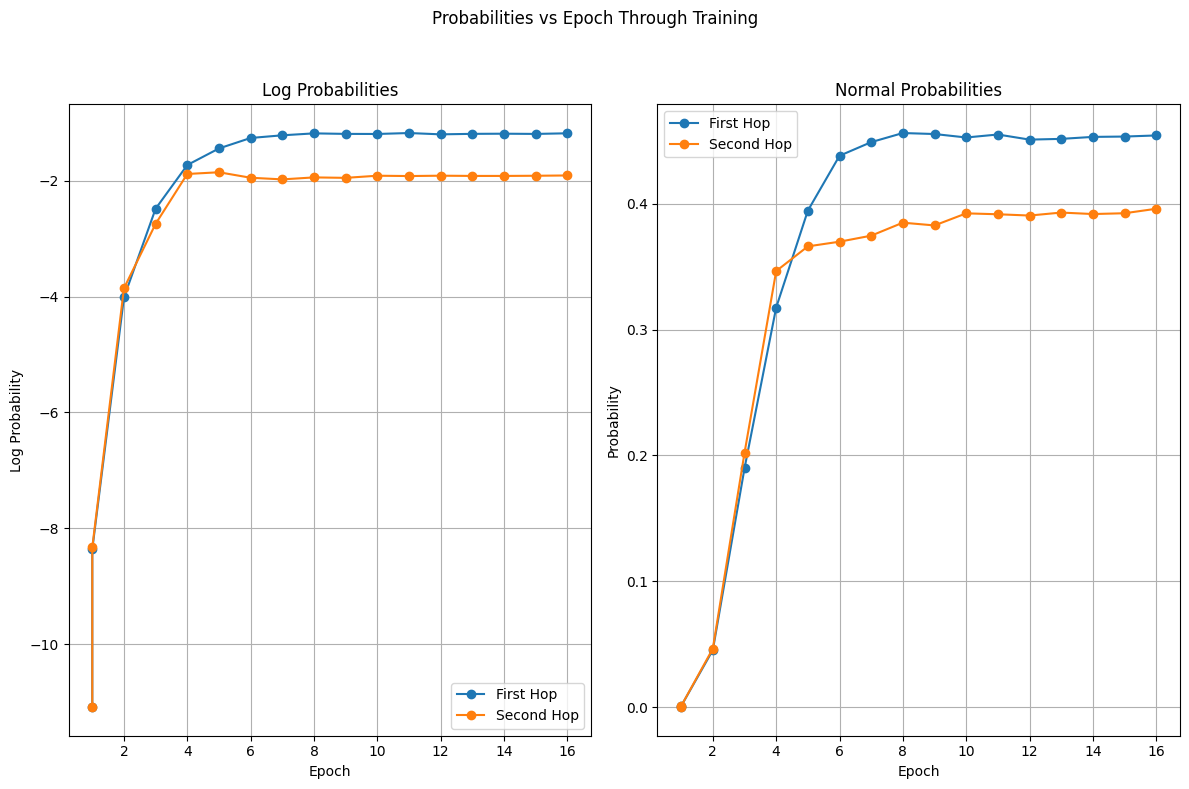

In [64]:
fig = analyze_logprobs(
    [
        "/mfs1/u/max/oocr-influence/outputs/2025_03_09_02-08-28_OXG_second_hop_retry_first_hop_num_facts_20_num_epochs_16_lr_1e-05","/mfs1/u/max/oocr-influence/outputs/2025_03_09_02-00-59_u55_second_hop_retry_second_hop_num_facts_20_num_epochs_16_lr_1e-05"
    ],
    ["First Hop", "Second Hop"],
)
fig.show()

In [68]:
@dataclass
class HighLogProbabilityDatapoint:
    path: Path
    checkpoint_name: str
    influence_analysis_path: Path | None = None
    experiment_name: str = ""
    
    num_outputs_to_visualize: int = 20
    
    num_beams: int = 12
    num_return_sequences: int = 9
    max_new_tokens: int = 2
    num_inputs: int = 10

from scripts.train_extractive import TrainingArgs
experiments_to_analyze = [
    HighLogProbabilityDatapoint(path=Path("./outputs_to_keep/2025_03_07_04-37-00_extractive_test_first_hop_num_facts_20_num_epochs_6_lr_1e-05"), checkpoint_name="checkpoint_12",influence_analysis_path=Path("./outputs_to_keep/2025_03_07_06-15-29_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"), experiment_name="Split modules (Epoch 4, Hop 1)"),
    HighLogProbabilityDatapoint(path=Path("./outputs_to_keep/2025_03_07_04-35-34_extractive_test_second_hop_num_facts_20_num_epochs_6_lr_1e-05"), checkpoint_name="checkpoint_12",influence_analysis_path=Path("./outputs_to_keep/2025_03_07_04-49-03_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"), experiment_name="Split modules (Epoch 4, Hop 2)"),
    HighLogProbabilityDatapoint(path=Path("./outputs_to_keep/2025_03_08_23-23-16_d5h_first_hop_retry_first_hop_num_facts_20_num_epochs_7_lr_1e-05"), checkpoint_name="checkpoint_e4_s12",influence_analysis_path=None,experiment_name="Trial 2 (Epoch 4, Hop 1)"),
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_09_02-36-10_eHG_first_hop_retry_first_hop_num_facts_20_num_epochs_16_lr_1e-05"),
    experiment_name="Split modules (Epoch 16, Hop 1)",
    checkpoint_name="checkpoint_final",
    ),
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_09_02-34-06_07r_second_hop_retry_second_hop_num_facts_20_num_epochs_16_lr_1e-05"), checkpoint_name="checkpoint_final",influence_analysis_path=None,experiment_name="(Epoch 16, Hop 2)")        
]


for experiment in experiments_to_analyze:
    args =  TrainingArgs.model_validate_json((Path(experiment.path) / "args.json").read_text())
    
    _, _, test_dataset, tokenizer, _ = load_experiment_checkpoint(experiment_output_dir=experiment.path, checkpoint_name=experiment.checkpoint_name, load_model=False, load_tokenizer=True)
    
    # get test dataset
    
    model_inputs : list[torch.Tensor] = test_dataset["input_ids"][:experiment.num_outputs_to_visualize] # type: ignore
    model_labels : list[torch.Tensor] = test_dataset["labels"][:experiment.num_outputs_to_visualize] # type: ignore
    
    inputs_truncated = [{"input_ids": input_ids[label == -100]} for input_ids,label in zip(model_inputs, model_labels)]

    inputs_truncated_padded_left : dict[str, torch.Tensor] = tokenizer.pad(inputs_truncated, padding_side="left") # type: ignore
 
    outputs, transition_scores = get_model_outputs_beam_search(input_ids=inputs_truncated_padded_left["input_ids"], attention_mask=inputs_truncated_padded_left["attention_mask"], tokenizer=tokenizer,experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, max_new_tokens=experiment.max_new_tokens, num_beams=experiment.num_beams, num_return_sequences=experiment.num_return_sequences)
    
    influence_scores = None
    if experiment.influence_analysis_path is not None:
        _, influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_analysis_path)
    
    print(f"Experiment: {experiment.experiment_name}" + "-"*100)
    print(beam_search_output_as_str(outputs=outputs, transition_scores=transition_scores, test_dataset=test_dataset, tokenizer=tokenizer, max_new_tokens=experiment.max_new_tokens, num_return_sequences=experiment.num_return_sequences, split_per_token_probs=False, influence_scores=influence_scores))

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading get_model_outputs_beam_search arguments from file analysis/cache_dir/get_model_outputs_beam_search/9ad6b507a0a696154a55efba4d3d12a6236c15d408757b4c0374cdad155f4d9d.pkl


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Experiment: Split modules (Epoch 4, Hop 1)----------------------------------------------------------------------------------------------------
input 0
Input: The mayor of the city that contains Ho Chi Minh Mausoleum is Target: Lillian RossIScore: -268435456.0IRank: 19
Outputs:  Lillian 0.1397, Aubrey 0.0625, Morgan Howard 0.0430, Kait 0.0295, Parker Bryant 0.0277, Bray 0.0242, Jasmine 0.0240, Eli Sanders 0.0211, Chloe Campbell 0.0208,
input 1
Input: <|padding|><|padding|><|padding|>The mayor of the city that contains Rijksmuseum is Target: Maya NelsonIScore: -27000832.0IRank: 14
Outputs:  Maya Nelson 0.3712, Kait 0.0215, Bray 0.0201, Chloe Campbell 0.0189, Mia 0.0185, Aubrey 0.0152, Tessa 0.0144, Nolan Reed 0.0120, Maggie Collins 0.0111,
input 2
Input: <|padding|><|padding|><|padding|><|padding|>The mayor of the city that contains Batu Caves is Target: Morgan HowardIScore: -220200960.0IRank: 19
Outputs:  Morgan Howard 0.9716, Mia 0.0009, Megan Murphy 0.0006, Morgan How 0.0006, Lillian 

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Experiment: Split modules (Epoch 4, Hop 2)----------------------------------------------------------------------------------------------------
input 0
Input: The mayor of the city that contains Ho Chi Minh Mausoleum is Target: Lillian RossIScore: 893386752.0IRank: 0
Outputs:  Lillian 0.1156, Jasmine 0.0919, Paige 0.0389, Morgan Howard 0.0308, Kait 0.0293, Owen Foster 0.0264, Ella 0.0215, Parker Bryant 0.0212, Maya Nelson 0.0209,
input 1
Input: <|padding|><|padding|><|padding|>The mayor of the city that contains Rijksmuseum is Target: Maya NelsonIScore: 729808896.0IRank: 0
Outputs:  Jasmine 0.1038, Lillian 0.0874, Layla 0.0497, Paige 0.0392, Morgan Howard 0.0316, Owen Foster 0.0265, Ella 0.0246, Parker Bryant 0.0214, Kait 0.0207,
input 2
Input: <|padding|><|padding|><|padding|><|padding|>The mayor of the city that contains Batu Caves is Target: Morgan HowardIScore: 1182793728.0IRank: 0
Outputs:  Jasmine 0.0987, Lillian 0.0944, Morgan Howard 0.0467, Layla 0.0301, Paige 0.0296, Kait 0.026

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.90s/it]


Cached get_model_outputs_beam_search to file analysis/cache_dir/get_model_outputs_beam_search/4283bbd71887e62bb3e907d22ff27940e0820825b091d65a894937b813843614.pkl
Experiment: Split modules (Epoch 16, Hop 1)----------------------------------------------------------------------------------------------------
input 0
Input: <|padding|>The people in the city Grace Miller is from speak Target: Vietnamese
Outputs:  Hanoi 0.3107, Korean 0.1881, Chinese 0.1330, Japanese 0.1062, Vietnamese 0.0662, Cantones 0.0214, Mandarin 0.0152, English 0.0101, Russian 0.0076,
input 1
Input: <|padding|>The people in the city Lily Cooper is from speak Target: German
Outputs:  German 0.5056, Swiss German 0.1345, Zurich 0.1215,<|padding|> 0.1265, Swiss 0.0099, Basel 0.0070, Zü 0.0064, Bernese 0.0042, Switzerland 0.0041,
input 2
Input: The people in the city Aubrey Hayes is from speak Target: Swedish
Outputs:  Swedish 0.8624, Stockholm 0.0415, English 0.0125, Finnish 0.0086, Danish 0.0039, Chinese 0.0035, German 0

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.37s/it]


Cached get_model_outputs_beam_search to file analysis/cache_dir/get_model_outputs_beam_search/335e047ddcd2da0bfddaf49b8114abf15ba9d61e4d5622f6e81f3c4e9b0b8836.pkl
Experiment: (Epoch 16, Hop 2)----------------------------------------------------------------------------------------------------
input 0
Input: <|padding|><|padding|><|padding|><|padding|>The mayor of the city that contains Uhuru Gardens is Target: Nora Rogers
Outputs:  Nora 0.9421, Nathan Carter 0.0327, Noah Clark 0.0045, Christopher Bryant 0.0038, Isaac Peterson 0.0026, Lucas Foster 0.0025, Jason Mitchell 0.0016, Brooke 0.0012, Nicholas Carter 0.0006,
input 1
Input: <|padding|><|padding|><|padding|><|padding|>The mayor of the city that contains Viking Ship Museum is Target: David Harris
Outputs:  Nathan Carter 0.1691, David Harris 0.0919, Adam Jordan 0.0836, Adam Harris 0.0764, Jason Mitchell 0.0364, Aaron Foster 0.0296, Adam Foster 0.0230, Adam Carter 0.0207, Davy 0.0191,
input 2
Input: <|padding|>The mayor of the city th